Problem statement :

Create a GUI so that we can write a digit ( 0-9), and after clicking recognize, the character is recognised along with the bounding box around it.

# 1. Load the Mnist dataset

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
# from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPool2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense


2025-03-11 21:23:01.349732: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/raghava/Documents/projects/2-HandWriiten digit localization on GUI,TFJS/handwritten_digits_project/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Load mnist dataset:
data=keras.datasets.mnist.load_data()

x_train_raw_data = data[0][0]
y_train = data[0][1]

half_size = len(data[1][0]) // 2  # use half of the testing data for "test" and other half for validataion

x_test_raw_data = data[1][0][:half_size]
y_test = data[1][1][:half_size]


x_val_raw_data = data[1][0][half_size:]
y_val = data[1][1][half_size:]



print("Shape of x_train:", x_train_raw_data.shape)
print("Shape of y_train:", y_train.shape)


print("Shape of x_test:", x_test_raw_data.shape)
print("Shape of y_test:", y_test.shape)

print("Shape of x_val:", x_val_raw_data.shape)
print("Shape of y_val:", y_val.shape)

# Define a sharpening kernel
sharpen_kernel = np.array([[ 0, -1,  0],
                           [-1,  8, -1],
                           [ 0, -1,  0]])
FULL_SHAPE = (80,80)

Shape of x_train: (60000, 28, 28)
Shape of y_train: (60000,)
Shape of x_test: (5000, 28, 28)
Shape of y_test: (5000,)
Shape of x_val: (5000, 28, 28)
Shape of y_val: (5000,)


In [ ]:
# Plot original and sharpened images side by side
fig, axes = plt.subplots(2, 4, figsize=(10, 5))  # 2 rows, 4 columns
fig.suptitle("Original vs. Sharpened Images", fontsize=14)

for i in range(4):
    original_img = x_train_raw_data[i]  # Original Image (28x28)
    sharpened_img = cv2.filter2D(original_img, -1, sharpen_kernel).astype(np.uint8)  # Ensuring same dtype
    # Original Image
    axes[0, i].imshow(original_img, cmap="gray")
    axes[0, i].set_title(f"Original {i}. True label: {y_train[i]}")
    axes[0, i].axis("off")

    # Sharpened Image
    axes[1, i].imshow(sharpened_img, cmap="gray")
    axes[1, i].set_title(f"Sharpened {i}. True label: {y_train[i]}")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()

print("Final x_train_raw_data shape:", x_train_raw_data.shape)
print("Final y_train shape:", y_train.shape)

# 2. Preparing the data for object localization 

In [ ]:
def preprocess_and_create_data(x_raw_data):
    y_box=[]
    x_new=[]
    def localize_obj(img_id):
        img_height = np.random.randint(20,FULL_SHAPE[0]-20)
        img_width = np.random.randint(20,FULL_SHAPE[0]-20)
        
        new = np.zeros(FULL_SHAPE)
        x = np.random.randint(0,FULL_SHAPE[0]-img_height)
        y = np.random.randint(0,FULL_SHAPE[0]-img_width)

        original_img = x_raw_data[img_id]
        sharpened_img = cv2.filter2D(original_img, -1, sharpen_kernel)  #sharpen the image

        image = cv2.resize(sharpened_img, dsize=(img_width,img_height))    
        
        new[x:x+img_height,y:y+img_width] = image
        x_new.append(new)
        y_box.append([y,x,img_height,img_width])
        
    
    # Normalize the images
    x_raw_data = x_raw_data / 255

    #cropping unnecessary part
    x_raw_data = x_raw_data[:, 2:26, 2:26]

    for i in range(len(x_raw_data)):
        localize_obj(i)
    return x_new,y_box

In [ ]:
x_train,y_train_box_data = preprocess_and_create_data(x_train_raw_data)

In [ ]:
x_test,y_test_box_data = preprocess_and_create_data(x_test_raw_data)

In [ ]:
x_val,y_val_box_data = preprocess_and_create_data(x_val_raw_data)

In [ ]:
plt.imshow(x_train[90], cmap="gray", vmin=0, vmax=1)
print(y_train_box_data[1])

In [ ]:
def plot_bb(img,x,y,height,width,pred_coords=[]):
    plt.imshow(img, cmap="gray", vmin=0, vmax=1)
    x_coor = x
    y_coor = y
    plt.plot([x_coor,x_coor+width] , [y_coor,y_coor],color='g',linewidth=2)
    plt.plot([x_coor,x_coor+width] , [y_coor+height,y_coor+height],color='g',linewidth=2)
    plt.plot([x_coor,x_coor] , [y_coor,y_coor+height],color='g',linewidth=2)
    plt.plot([x_coor+width,x_coor+width] , [y_coor,y_coor+height],color='g',linewidth=2)    
    if len(pred_coords)==4:
        x1,y1,hei,wid = pred_coords
        limit = FULL_SHAPE[0]-1
        if x1 < limit and y1 < limit :
            x2 =min(limit , x1+wid) 
            y2 =min(limit , y1+hei )
            plt.plot([x1,x2] , [y1,y1],color='r',linewidth=2)
            plt.plot([x1,x2] , [y2,y2],color='r',linewidth=2)
            plt.plot([x1,x1] , [y1,y2],color='r',linewidth=2)
            plt.plot([x2,x2] , [y1,y2],color='r',linewidth=2)

In [ ]:
image_id = 90
plot_bb(x_train[image_id], y_train_box_data[image_id][0] , y_train_box_data[image_id][1] ,y_train_box_data[image_id][2] , y_train_box_data[image_id][3] , [7,2,14,15])

In [ ]:
for i in range(20):
    plt.subplot(4,5,i+1)
    plot_bb(x_train[i], y_train_box_data[i][0] , y_train_box_data[i][1],y_train_box_data[i][2],y_train_box_data[i][3])
plt.show()

In [ ]:
def form_tensorflow_dataset(x, y, y_box):
    x = np.array(x).reshape(len(x), FULL_SHAPE[0], FULL_SHAPE[1], 1)
    y = np.array(y)  # Ensure y is a NumPy array
    y_box = np.array(y_box, dtype=np.float32)  # Convert y_box to NumPy array with explicit dtype
    
    dataset1 = tf.data.Dataset.from_tensor_slices(x.astype(np.float32))
    dataset2 = tf.data.Dataset.from_tensor_slices({'class_out': y, 'box_out': y_box})
    dataset = tf.data.Dataset.zip((dataset1, dataset2))
    dataset = dataset.shuffle(200)
    dataset = dataset.batch(64)
    dataset = dataset.prefetch(4)

    print(x.shape)
    print(y.shape)
    print(y_box.shape)  # Print shape instead of length
    return dataset


In [ ]:
train_dataset = form_tensorflow_dataset(x_train,y_train, y_train_box_data)
test_dataset = form_tensorflow_dataset(x_test,y_test, y_test_box_data)
val_dataset = form_tensorflow_dataset(x_val,y_val, y_val_box_data)

In [ ]:
print(len(train_dataset))
print(len(test_dataset))
print(len(val_dataset))

# 3. Creating CNN model for image classifiation and object localization

##### For better model performance : 
- Data Augumentaion
- increase the complexity of the model
- use dropout regularization
- batch normalization
- Scale the image

In [ ]:

# inp = Input(shape = x_train[0].shape , name = 'image')
# x = inp
# for i in range(0,3):
#     n_filters = 2**(4+i)
#     x = Conv2D(n_filters,3,activation="relu")(x)
#     x = MaxPool2D(2)(x)

# x = BatchNormalization()(x)
# x=Flatten()(x)
# x = Dense(512 , activation="relu")(x)
# x = Dense(256 , activation='relu')(x)

# class_out = Dense(10 , activation='softmax' , name='class_out')(x)


# box_out = Dense(4, name='box_out')(x)


# model = keras.models.Model(inp , [class_out,box_out])
# model.summary()


inp = Input(shape=x_train[0].shape + (1,), name='image')  # Expand the shape
x = inp

# First Convolutional Block
x = Conv2D(32, (3, 3), activation='relu', padding='same', data_format='channels_last')(x)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same', data_format='channels_last')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid')(x)
x = Dropout(0.25)(x)

# Second Convolutional Block
x = Conv2D(64, (3, 3), activation='relu', padding='same', data_format='channels_last')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same', data_format='channels_last')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid')(x)
x = Dropout(0.25)(x)

# Fully Connected Layers
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Output Layers
class_out = Dense(10, activation='softmax', name='class_out')(x)
box_out = Dense(4, name='box_out')(x)

model = Model(inp, [class_out, box_out])
model.summary()


# 4. Custom metric : IOU
- getting error while using this as my metric, will find the solution soon

In [3]:
class IOU(tf.keras.metrics.Metric):
    def __init__(self, **kwargs):
        super(IOU , self).__init__(**kwargs)
        
        self.iou = self.add_weight(name='iou', initializer='zeros')
        self.total_iou = self.add_weight(name='total_iou', initializer='zeros')
        self.num_ex = self.add_weight(name='num_ex', initializer='zeros')
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        def get_box(y):
            y = tf.cast(y, tf.float32)
            rows, cols, height, width = y[:, 0], y[:, 1], y[:, 2], y[:, 3]
            x1, y1 = rows, cols
            x2, y2 = x1 + width, y1 + height
            return x1, y1, x2, y2
        
        def get_area(x1, y1, x2, y2):
            return tf.math.abs(x2 - x1) * tf.math.abs(y2 - y1)
        
        tx1, ty1, tx2, ty2 = get_box(y_true)
        px1, py1, px2, py2 = get_box(y_pred)
        
        x1 = tf.maximum(tx1, px1)
        x2 = tf.minimum(tx2, px2)
        y1 = tf.maximum(ty1, py1)
        y2 = tf.minimum(ty2, py2)
        
        i_area = get_area(x1, y1, x2, y2)
        u_area = get_area(tx1, ty1, tx2, ty2) + get_area(px1, py1, px2, py2) - i_area
        
        iou = tf.math.divide(i_area, u_area)
        self.num_ex.assign_add(1)
        self.total_iou.assign_add(tf.reduce_mean(iou))
        self.iou.assign(tf.math.divide(self.total_iou, self.num_ex))
        
    def result(self):
        return self.iou
    
    def reset_state(self):
        self.iou.assign(0)
        self.total_iou.assign(0)
        self.num_ex.assign(0)


# 5. Compiling the model

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model.compile(
loss = {
  'class_out' : 'sparse_categorical_crossentropy',
    'box_out':'mse'
},
    
optimizer=optimizer,
metrics={
    'class_out' :'accuracy',
    'box_out':IOU()                   # here we need to define our custom metric : IOU
}
)

#Define LearningRateScheduler
reduce_lr = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 0.9 ** epoch)


# 6. Custom callback : Model testing

In [ ]:
testing = test_dataset.take(1)
for i in testing.as_numpy_iterator():
    img = i[0]
    y_true= i[1]['class_out']
    bb_true = i[1]['box_out']

In [ ]:
def test_model(model) : 
    c,bb_pred =model.predict(img)
    
    y_pred = []
    for i in c:
        y_pred.append(np.argmax(i))
    y_pred=np.array(y_pred).reshape(len(c),1)        
        
    # we have y_true,y_pred,bb_true,bb_pred
    
    for i in range(5):
        plt.subplot(1,5,i+1)
        plot_bb(img[i], bb_true[i][0] , bb_true[i][1],bb_true[i][2],bb_true[i][3], bb_pred[i])
#         plt.xlabel('Truth : '+str( y_true[i][0]))
        plt.xlabel('pred : '+ str(y_pred[i][0]) )
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [ ]:
test_model(model)

In [ ]:
# creating clustom callback so that we can view the test iages while training itself.

class ShowValImages(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs=None):
        test_model(self.model)

In [ ]:
callbacks_list = [ShowValImages(), reduce_lr]

# 7. Training the model - i've done the training on colab

In [ ]:
history = model.fit(train_dataset,epochs=40,validation_data=val_dataset,callbacks=callbacks_list)

In [ ]:
plt.figure(figsize=(13, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train','Test'])
plt.grid()
plt.show()

# 8. Saving/Loading the model

In [ ]:
model.save('digits_localization_model_version1.h5')

In [4]:
model = tf.keras.models.load_model(
    "digits_localization_model_version1.h5",
    custom_objects={'IOU': IOU, 'mse': keras.losses.MeanSquaredError()}
)

# 9. Testing and Evaluating the model

In [27]:
def predict(i):
    yyyy , bbbb = model.predict(x_train[i].reshape(1,FULL_SHAPE[0],FULL_SHAPE[1],1))
    plot_bb(x_train[i], y_train_box_data[i][0] , y_train_box_data[i][1],y_train_box_data[i][2],y_train_box_data[i][3] , bbbb[0])
    plt.xlabel("Truth : "+ str(y_train[i][0]))
    plt.ylabel("Predicted : "+ str(np.argmax(yyyy)))
    plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


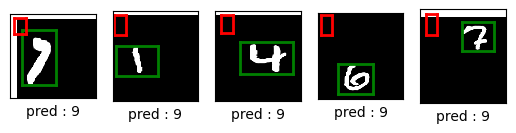

In [28]:
# for i in range(20,30):
#     predict(21+i)

test_model(model)

In [29]:
model.evaluate(train_dataset)

 99/938 ━━━━━━━━━━━━━━━━━━━━ 2:46 199ms/step - box_out_iou: 0.3578 - box_out_loss: 1577.0424 - class_out_accuracy: 0.0990 - class_out_loss: 2.5941 - loss: 1579.6364

KeyboardInterrupt: 

In [ ]:
model.evaluate(val_dataset)

In [30]:
imgs=[]
y_true=[]
bb_true=[]
for i in val_dataset.as_numpy_iterator():
    imgs.append(i[0])
    
    y_true.append(np.expand_dims(i[1]['class_out'], axis=1))
    bb_true.append(i[1]['box_out'])
imgs=np.vstack(imgs)
y_true=np.vstack(y_true)
bb_true=np.vstack(bb_true)

2025-03-11 20:44:19.493991: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [31]:
c,bb_pred =model.predict(imgs)
y_pred = []
for i in c:
    y_pred.append(np.argmax(i))
y_pred=np.array(y_pred).reshape(len(c),1)    

157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 99ms/step


In [32]:
print( len(y_pred))
print(len(imgs))
print(len(bb_true))
print(len(y_true))

5000
5000
5000
5000


In [33]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

print(accuracy_score(y_pred,y_true))
print("_____________________________________________________")
print(classification_report(y_pred,y_true))
print("_____________________________________________________")
cm=confusion_matrix(y_pred,y_true)
print(cm)

0.0948
_____________________________________________________
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.01      0.02      0.01       237
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.96      0.10      0.18      4761

    accuracy                           0.09      5000
   macro avg       0.10      0.01      0.02      5000
weighted avg       0.92      0.09      0.17      5000

_____________________________________________________
[[  0   0   0   0   0   0   0   0   0   0]
 [ 41   4  26  18  25  20  31  20  33  19]
 [  0   0   0   0   0   0   0   0   0   

/Users/raghava/Documents/projects/2-HandWriiten digit localization on GUI,TFJS/handwritten_digits_project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/raghava/Documents/projects/2-HandWriiten digit localization on GUI,TFJS/handwritten_digits_project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/raghava/Documents/projects/2-HandWriiten digit localization on GUI,TFJS/handwritten_digits_project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarn

Text(95.72222222222221, 0.5, 'Truth')

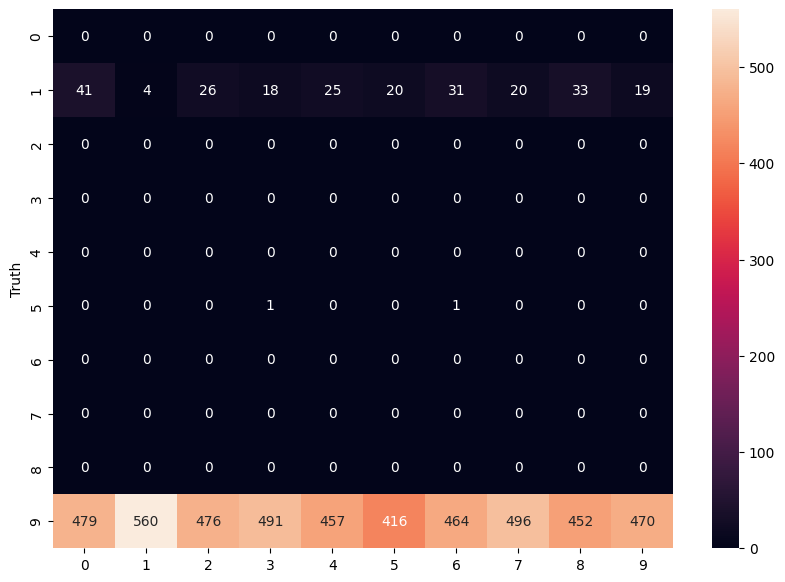

In [34]:
import seaborn as sns
plt.figure(figsize=(10,7))
sns.heatmap(cm,annot=True,fmt='d')
plt.ylabel("Truth")

# 10. Recognizing handwritten digits on paint app:

In [ ]:
model = tf.keras.models.load_model("digits_localization_model_version1.h5",custom_objects={'IOU': IOU})

Scaling values: [80]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Prob: 100.00% | Label: 1 | Bounding Box: [[23.978735 22.197569 25.509884 26.343052]]
Scaling values: [80]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Prob: 100.00% | Label: 1 | Bounding Box: [[23.978735 22.197569 25.509884 26.343052]]


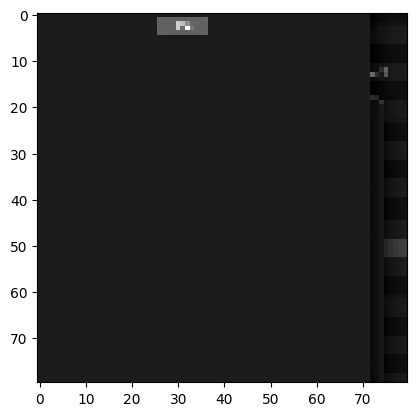

In [7]:
from tkinter import *
import PIL.ImageGrab as ImageGrab
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Initialize Tkinter Window
root = Tk()
root.geometry('450x450+668+100')
root.title('Handwriting Recognition')

# # Expandable frame to ensure everything fits
# frame = LabelFrame(root, text='Enter a Character here')
# frame.pack(fill=BOTH, expand=True)  # Ensure the frame expands properly

# # Create Canvas First (Ensuring Visibility)
# canvas = Canvas(frame, width=350, height=350, bg='black')
# canvas.pack()

frame = LabelFrame(root, text='Enter a Character here')
frame.pack(fill=BOTH, expand=True)  # Ensure it expands properly

canvas = Canvas(frame, width=350, height=350, bg='black')
canvas.grid(row=0, column=0, sticky="nsew")
frame.grid_rowconfigure(0, weight=1)
frame.grid_columnconfigure(0, weight=1)
root.update_idletasks()
# Frame for Buttons and Labels
frame2 = Frame(root)
frame2.pack()

# Define Recognize Function
def recognize():
    global gray
    global pred
    
    # Get Canvas Coordinates
    x = root.winfo_rootx() + canvas.winfo_x() + 48
    y = root.winfo_rooty() + canvas.winfo_y()
    xx = x + canvas.winfo_width() - 2
    yy = y + canvas.winfo_height()
    
    # Capture Image from Canvas
    image = ImageGrab.grab(bbox=(x, y, xx, yy))
    x_recog = np.asarray(image)
    
    lis = [80]  # List of scaling values
    print("Scaling values:", lis)
    
    all_prob, all_y, all_bb = [], [], []

    # Padding function
    def pad_frame_once(src_: list, pad) -> list:
        output = [[pad, *line, pad] for line in src_]
        return [[pad] * len(output[0]), *output, [pad] * len(output[0])]

    def pad_grid(src_, padding_size: int, pad=0):
        reference = src_
        for _ in range(padding_size):
            reference = pad_frame_once(reference, pad)
        return reference

    # Process image for each scaling value
    for s in lis:
        resized = cv2.resize(x_recog, (s, s))
        gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
        
        # Ensure FULL_SHAPE is defined somewhere in the script
        gray = pad_grid(gray, (FULL_SHAPE[0] - s) // 2)
        plt.imshow(gray, cmap='gray')  # Use colormap to visualize grayscale

        # Reshape for Model Input
        gray_1 = np.array(gray).reshape(FULL_SHAPE[0], FULL_SHAPE[1], 1)
        gray = gray_1.reshape(1, FULL_SHAPE[0], FULL_SHAPE[1], 1) / 255.0  # Normalize

        # Predict using the model
        pred, bb_pred = model.predict(gray)

        all_bb.append(bb_pred)
        prob = (pred / pred[0].sum()).max() * 100
        high_index = np.argmax(pred)

        all_y.append(high_index)
        all_prob.append(prob)

    # Determine Best Prediction
    right_index = np.argmax(np.array(all_prob))
    prob = all_prob[right_index]
    high_index = all_y[right_index]
    bb_pred = all_bb[right_index]

    print(f"Prob: {prob:.2f}% | Label: {high_index} | Bounding Box: {bb_pred}")

    # Scale Bounding Box
    scale_val = lis[right_index]
    x1 = bb_pred[0][0] * 350 / FULL_SHAPE[0]
    y1 = bb_pred[0][1] * 350 / FULL_SHAPE[0]
    x2 = x1 + bb_pred[0][3] * 350 / FULL_SHAPE[0]
    y2 = y1 + bb_pred[0][2] * 350 / FULL_SHAPE[0]

    # Draw Bounding Box and Label on Canvas
    canvas.create_rectangle(x1, y1, x2, y2, outline="green", width=2)
    canvas.create_text(x1 + 2, y1 - 6, text=str(high_index), fill="white", font=('Helvetica', 15, 'bold'))
    canvas.create_text(x2 - 10, y1 - 6, text=f'{prob:.2f}%', fill="white", font=('Helvetica', 15, 'bold'))

    # Update Labels
    label.config(text=f'The character is: {high_index}')
    label2.config(text=f'Accuracy: {prob:.2f}%')

# Dragging Function for Drawing
def dragging(event):
    canvas.create_oval(event.x - 7, event.y - 7, event.x + 7, event.y + 7, fill='white', outline='white')

canvas.bind('<B1-Motion>', dragging)

# Clear Function
def clear():
    canvas.delete('all')

# Buttons and Labels
Button(frame2, text='Recognize', anchor=W, command=recognize).grid(row=0, column=0)
Button(frame, text='Clear', command=clear).pack()

label = Label(frame2, text='The character is: ')
label.grid(row=0, column=1)

label2 = Label(frame2, text='Accuracy: ')
label2.grid(row=1, column=1)

# Run Tkinter Event Loop
root.mainloop()

In [11]:
# Import Module
from tkinter import *

# create root window
root = Tk()

# root window title and dimension
root.title("Welcome to GeekForGeeks")
# Set geometry(widthxheight)
root.geometry('350x200')

# adding a label to the root window
lbl = Label(root, text = "Are you a Geek?")
lbl.grid()

# function to display text when
# button is clicked
def clicked():
    lbl.configure(text = "I just got clicked")

# button widget with red color text
# inside
btn = Button(root, text = "Click me" ,
             fg = "red", command=clicked)
# set Button grid
btn.grid(column=1, row=0)

# Execute Tkinter
root.mainloop()


# 11. Converting to model.json using tensorflow.js

In [ ]:
!pip install tensorflowjs

In [ ]:
!tensorflowjs_converter --input_format=keras digits_localization_model.h5 new_json_digits_localization_model